## Objetivo de este Notebook

* Obtenere el pronóstico del Precio de Bolsa Nacional desde la librería pydatasimem usando un modelo de regresión lineal y de series de tiempo.

### Carga de la clase VariableSIMEM

En la siguiente celda se importa el objeto VariableSIMEM, que contiene las funciones necesarias para cumplir el objetivo anteriormente mencionados; además de las otras librerías que se necesitarán.

In [ ]:
import sys
sys.path.append('../')

from src.variable import VariableSIMEM

# from pydataxm.pydatasimem import VariableSIMEM

In [40]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

### Consultar el listado de variables disponibles dentro de la clase

En la siguiente celda se muestra como consultar el listado de variables disponibles con el fin de buscar el código de la variable deseada.

In [3]:
lisatado_variables = VariableSIMEM.get_collection()
lisatado_variables.head()

,CodigoVariable,Nombre
0,AportesHidricosMasa,Aportes hídricos de las series hidrológicas
1,AportesHidricosMasaPSS95,Aportes hídricos para un 95% de Probabilidad d...
2,CantidadVentasContratosSICEP,Cantidad ventas en contratos del SICEP
3,CapacidadUtilMasa,Capacidad útil del embalse
4,CargoMonomio,Cargos por uso


### Consultar el código de una variable de interés
En la siguiente celda se muestra como consultar el código de una variable a través de su nombre

In [5]:
nombre_variable = 'precio de bolsa nacional'
cod_variable = lisatado_variables.query("Nombre.str.lower().str.contains(@nombre_variable.lower())")['CodigoVariable'].values
print(cod_variable)

['PB_Nal']


Una vez obtenido el código de la variable de interés, se debe inicializar una instancia de la clase VariableSIMEM con este, dos fechas de interés y la versión es específica que se desea de cada mes ó `0` para obtener la versión máxima de cada mes.

En este caso como se desea la máxima versión del precio de bolsa nacional, el valor para el parámetro versión será `0`.

In [11]:
cod_variable = 'PB_Nal'
fecha_inicio = '2023-01-01'
fecha_fin = '2024-12-31'
version = 0

pb_nal = VariableSIMEM(cod_variable, fecha_inicio, fecha_fin, version)

### Consultar la información de la variable

En este caso se está consultando información del `Precio de bolsa nacional` desde 2020 hasta 2024.

In [12]:
data_pbnal = pb_nal.get_data()
data_pbnal.head()

****************************************************************************************************
Initializing object
The object has been initialized with the dataset: "Precio de bolsa horario"
****************************************************************************************************
Inicio consulta sincronica
Creacion url: 0.0
Extraccion de registros: 96.70569849014282
End of data extracting process
****************************************************************************************************
****************************************************************************************************
Initializing object
The object has been initialized with the dataset: "Versiones de factura para la liquidación mensual"
****************************************************************************************************
Inicio consulta sincronica
Creacion url: 0.00494074821472168
For the URL: https://www.simem.co/backend-files/api/PublicData?startdate=2024-12-14&enddate=2024-1

,,CodigoVariable,CodigoDuracion,UnidadMedida,Valor
FechaHora,Version,,,,
2023-01-31 23:00:00,TX6,PB_Nal,PT1H,COP/kWh,621.1978
2023-01-31 22:00:00,TX6,PB_Nal,PT1H,COP/kWh,621.1978
2023-01-31 21:00:00,TX6,PB_Nal,PT1H,COP/kWh,698.1978
2023-01-31 20:00:00,TX6,PB_Nal,PT1H,COP/kWh,736.1978
2023-01-31 19:00:00,TX6,PB_Nal,PT1H,COP/kWh,736.1978


### Creación de los modelos

En las siguientes celdas se crean dos modelos simples para el pronóstico del precio de bolsa nacional para 2 meses.

#### Modelo ARIMA (Serie de tiempo)

                               SARIMAX Results                                
Dep. Variable:                  Valor   No. Observations:                  731
Model:                 ARIMA(5, 0, 0)   Log Likelihood               -4883.150
Date:                Thu, 08 May 2025   AIC                           9780.300
Time:                        16:18:14   BIC                           9812.461
Sample:                    01-01-2023   HQIC                          9792.707
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        563.4895    124.481      4.527      0.000     319.511     807.468
ar.L1          0.5892      0.017     34.598      0.000       0.556       0.623
ar.L2          0.0234      0.026      0.915      0.3

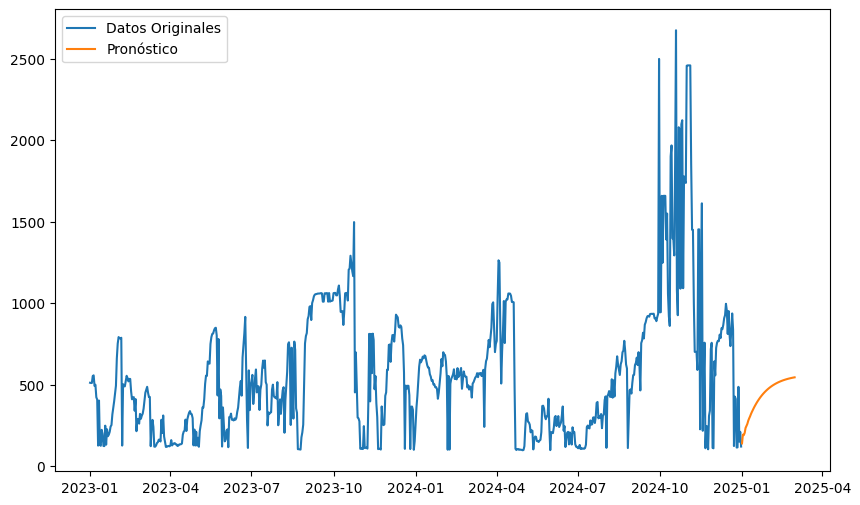

In [49]:
# Se crea una copia del dataset sin los índices
data = data_pbnal.copy()
data.reset_index(inplace=True)
df = pd.DataFrame(data)

# Se verifica que la comumna fecha este en formato datetime
df['FechaHora'] = pd.to_datetime(df['FechaHora'])

# Se establece la columna 'date' como el índice con frecuencia
df.set_index('FechaHora', inplace=True)
df = df.asfreq('D')

# Se ajusta el modelo ARIMA
model = ARIMA(df['Valor'], order=(5, 0, 0))
model_fit = model.fit()

# Resumen del modelo
print(model_fit.summary())

# Pronóstico valores futuros para los próximos 2 meses (aproximadamente 60 días)
forecast = model_fit.forecast(steps=60)
print(forecast)

# Gráfica los datos originales y el pronóstico
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Valor'], label='Datos Originales')
plt.plot(pd.date_range(start=df.index[-1], periods=61, freq='D')[1:], forecast, label='Pronóstico')
plt.legend()
plt.show()


#### Modelo de regresión lineal

d:\repos\pydataxm-practica2025\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


[792.96789393 793.59488374 794.22187356 794.84886338 795.4758532
 796.10284301 796.72983283 797.35682265 797.98381247 798.61080228
 799.2377921  799.86478192 800.49177173 801.11876155 801.74575137
 802.37274119 802.999731   803.62672082 804.25371064 804.88070046
 805.50769027 806.13468009 806.76166991 807.38865972 808.01564954
 808.64263936 809.26962918 809.89661899 810.52360881 811.15059863
 811.77758845 812.40457826 813.03156808 813.6585579  814.28554772
 814.91253753 815.53952735 816.16651717 816.79350698 817.4204968
 818.04748662 818.67447644 819.30146625 819.92845607 820.55544589
 821.18243571 821.80942552 822.43641534 823.06340516 823.69039497
 824.31738479 824.94437461 825.57136443 826.19835424 826.82534406
 827.45233388 828.0793237  828.70631351 829.33330333 829.96029315]


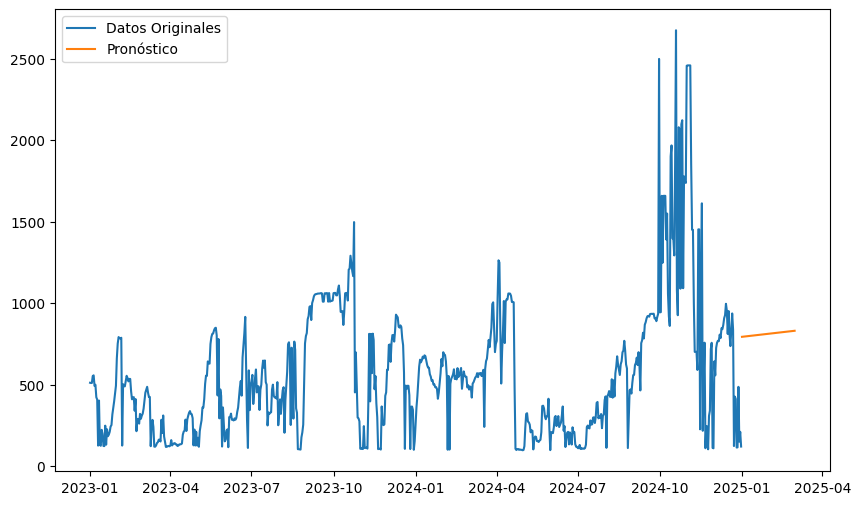

In [50]:
# Se crea una copia del dataset sin los índices
data = data_pbnal.copy()
data.reset_index(inplace=True)
df = pd.DataFrame(data)

# Se verifica que la comumna fecha este en formato datetime
df['FechaHora'] = pd.to_datetime(df['FechaHora'])

# Establece la columna 'FechaHora' como el índice y asegúrate de que tenga una frecuencia asociada
df.set_index('FechaHora', inplace=True)
df = df.asfreq('D')

# Se preparan los datos para la regresión lineal ya que se necesitan columnas con valores numéricos
df['timestamp'] = df.index.astype(np.int64)
X = df[['timestamp']]
y = df['Valor']

# Se ajusta el modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# Pronóstico valores futuros para los próximos 2 meses (aproximadamente 60 días)
future_timestamps = (pd.date_range(start=df.index[-1], periods=61, freq='D')[1:]).astype(np.int64)
forecast = model.predict(future_timestamps.values.reshape(-1, 1))
print(forecast)

# Gráfica los datos originales y el pronóstico
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Valor'], label='Datos Originales')
plt.plot(pd.date_range(start=df.index[-1], periods=61, freq='D')[1:], forecast, label='Pronóstico')
plt.legend()
plt.show()
